This notebook runs the event segmentation analyses.

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import brainiak.eventseg.event as event
import hypertools as hyp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
import pickle

def score_model(mcorr, model, k, s):
    i1, i2 = np.where(np.round(model.segments_[0])==1)
    w = np.zeros_like(model.segments_[0])
    w[i1,i2] = 1
    w = np.dot(w, w.T).astype(bool)
    return mcorr[w].mean()/mcorr[~w].mean() - k/s
    
def reduce_model(m, ev):
    """Reduce a model based on event labels"""
    w = (np.round(ev.segments_[0])==1).astype(bool)
    return np.array([m[wi, :].mean(0) for wi in w.T])

%matplotlib inline

## Setting paths

In [2]:
datadir = '../../../data/processed/'

## Load data

In [3]:
video_model, recall_models = np.load(datadir+'models_t100_v50_r10_resampled.npy', allow_pickle=True)

## Find optimal k for video model

In [43]:
m=[]
corrmat = np.corrcoef(video_model)
for i, events in enumerate(range(2, 51)):
    ev = event.EventSegment(events)
    ev.fit(video_model)
    t = np.round(ev.segments_[0]).astype(int)
    mask = np.sum(list(map(lambda x: np.outer(x, x), t.T)), 0).astype(bool)
    within = corrmat[mask].mean()
    across = corrmat[~mask].mean()
    m.append((within, across, within/across))

## Plot the within and across correlation values as a function of k

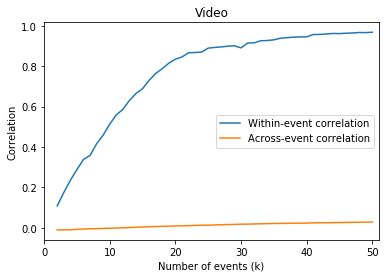

In [17]:
plt.plot([np.nan]*2 + list(map(lambda x: x[0], m)), label='Within-event correlation')
plt.plot([np.nan]*2 + list(map(lambda x: x[1], m)), label='Across-event correlation')
plt.xlim(0, 51)
# plt.ylim(-.1, 1)
plt.legend()
plt.ylabel('Correlation')
plt.xlabel('Number of events (k)')
plt.title('Video')
plt.show()

## Plot the ratio of within/across ratio as a function of k

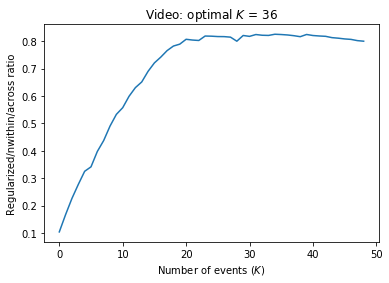

In [42]:
t=list(map(lambda x: x[0]/(x[1]-min([i[2] for i in vm])), m))
t/=np.max(t)
for i, v in enumerate(t):
    t[i]-=(i+2)/250
plt.plot(t)
plt.ylabel('Regularized/nwithin/across ratio')
plt.xlabel('Number of events ($K$)')
maxk_video = np.argmax(t) + 2
plt.title(f'Video: optimal $K$ = {maxk_video}')
plt.show()

## Fit event segmentation model to video

In [7]:
ev = event.EventSegment(maxk_video)
ev.fit(video_model)
video_events = reduce_model(video_model, ev)

## Save models

In [8]:
with open('../../../data/processed/video_eventseg_model', 'wb') as f:
    pickle.dump(ev, f)
np.save('../../../data/processed/video_events', video_events)

## Get video event times

In [9]:
video_event_times = []
for s in ev.segments_[0].T:
    tp = np.where(np.round(s)==1)[0]
    video_event_times.append((tp[0], tp[-1]))
np.save(datadir+'video_event_times', video_event_times)

## Fit event segmentation model to recall

In [44]:
ks = list(range(2, 51))
sub_cs = {}

for i, sub in enumerate(recall_models):
    print(i)
    mcorr = np.corrcoef(sub)
    cs = []
    for k in ks:
        ev = event.EventSegment(k)
        ev.fit(sub)
        i1, i2 = np.where(np.round(ev.segments_[0])==1)
        w = np.zeros_like(ev.segments_[0])
        w[i1,i2] = 1
        w = np.dot(w, w.T).astype(bool)
        within = mcorr[w].mean()
        across = mcorr[~w].mean()
        cs.append((within, across, within/across))
        
    sub_cs[i] = cs

In [9]:
sns.set_context('paper')

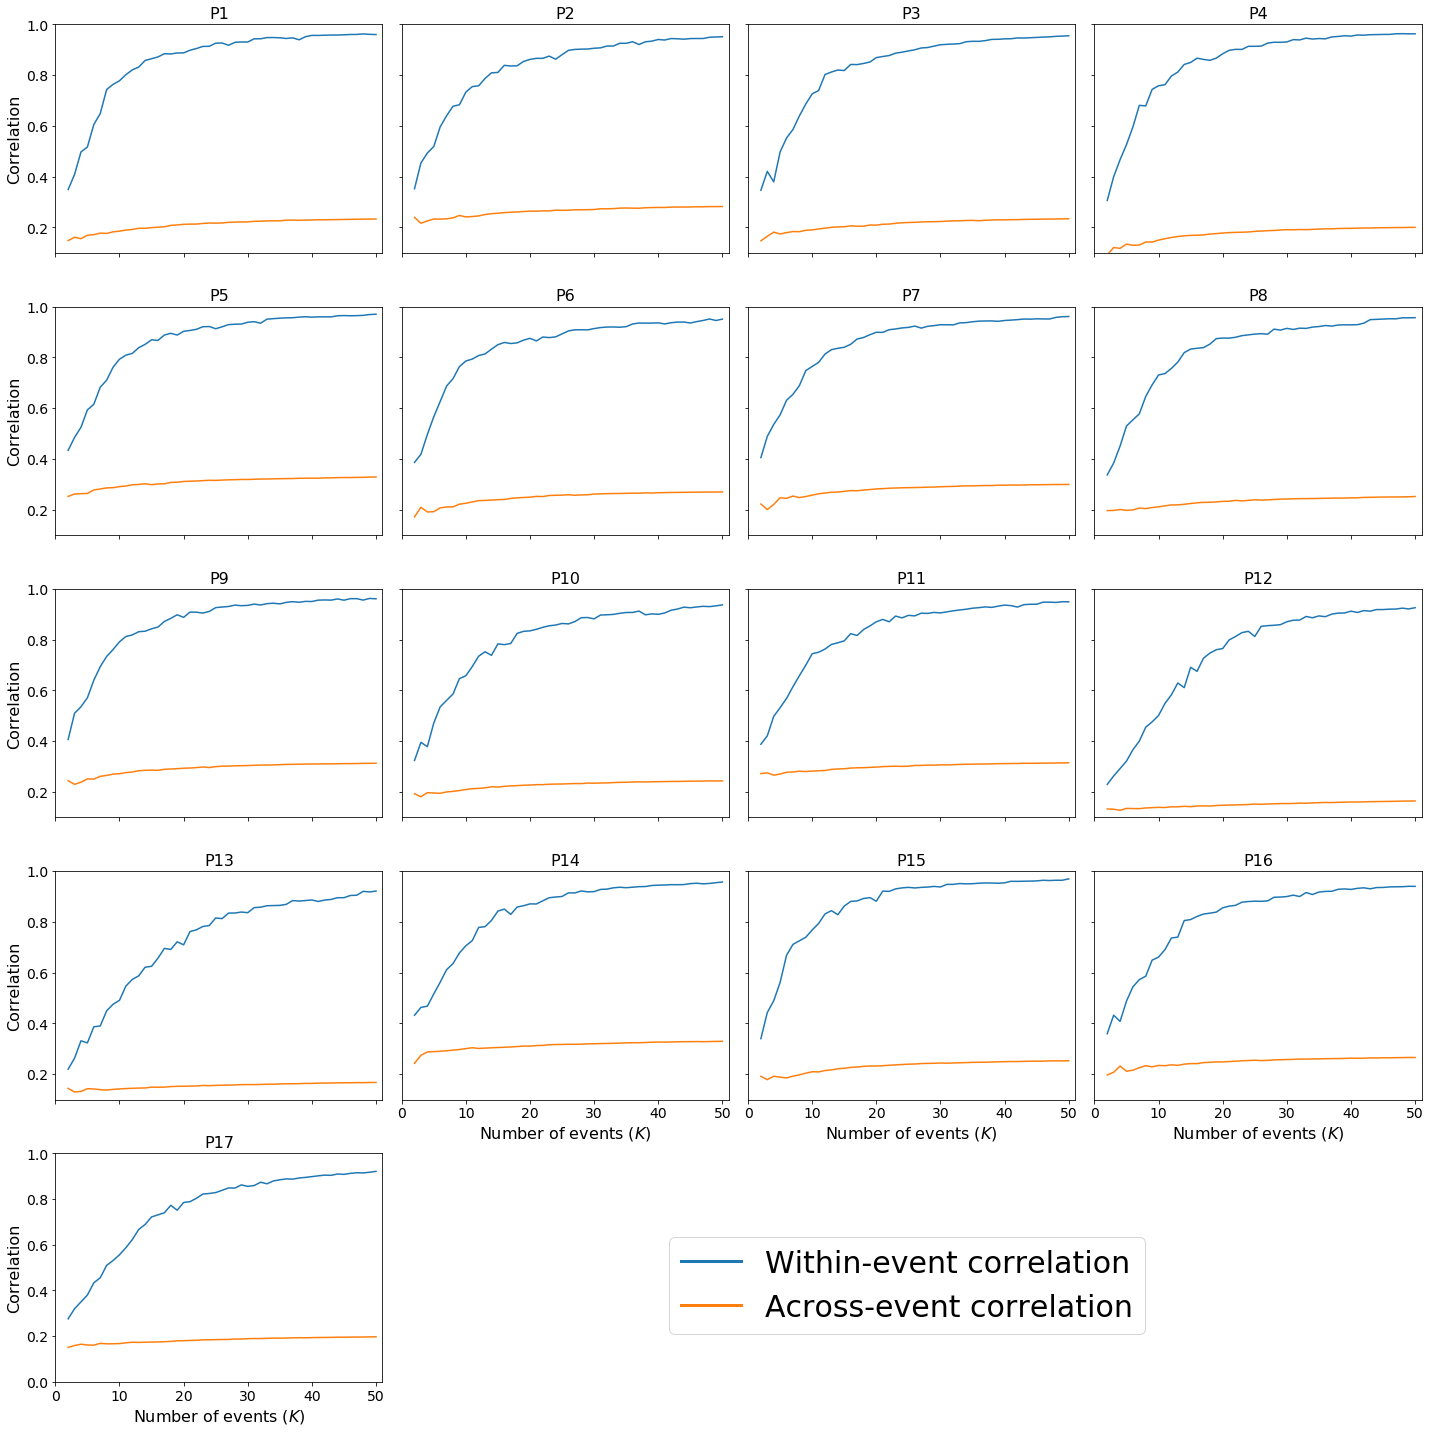

In [28]:
fig, axarr = plt.subplots(nrows=5, ncols=4, sharey=True)
fig.set_size_inches(20,20)
axarr = axarr.flatten()

for (sub, cs), ax in zip(sub_cs.items(), axarr):
    ax.plot([np.nan]*2 + list(map(lambda x: x[0], cs)), label='Within-event correlation')
    ax.plot([np.nan]*2 + list(map(lambda x: x[1], cs)), label='Across-event correlation')
    ax.set_ylabel('Correlation')
    ax.set_title(f'P{sub+1}', fontsize=16)
    ax.set_xlim(0, 51)
    ax.set_ylim(.1, 1)
    ax.set_xticks(list(range(0, 51, 10)))
    
    if not sub % 4:
        ax.set_ylabel('Correlation', fontsize=16)
        ax.set_yticks(np.arange(0, 1.1, .2))
        ax.tick_params(axis='y', labelsize=14)
    else:
        ax.set_ylabel('')

    if sub >= 13:
        ax.set_xlabel('Number of events ($K$)', fontsize=16)
        ax.tick_params(axis='x', labelsize=14)
    else:
        ax.set_xlabel('')
        ax.set_xticklabels([])
    
axarr[-3].axis('off')
axarr[-2].axis('off')
axarr[-1].axis('off')
plt.tight_layout()
plt.subplots_adjust()

handles, labels = axarr[0].get_legend_handles_labels()
legend = plt.legend(handles, labels, fontsize=30, bbox_to_anchor=(.2, .7))
for l in legend.legendHandles:
    l.set_linewidth(3)
# plt.savefig('../../../paper/figs/k_corrs.pdf')
plt.show()

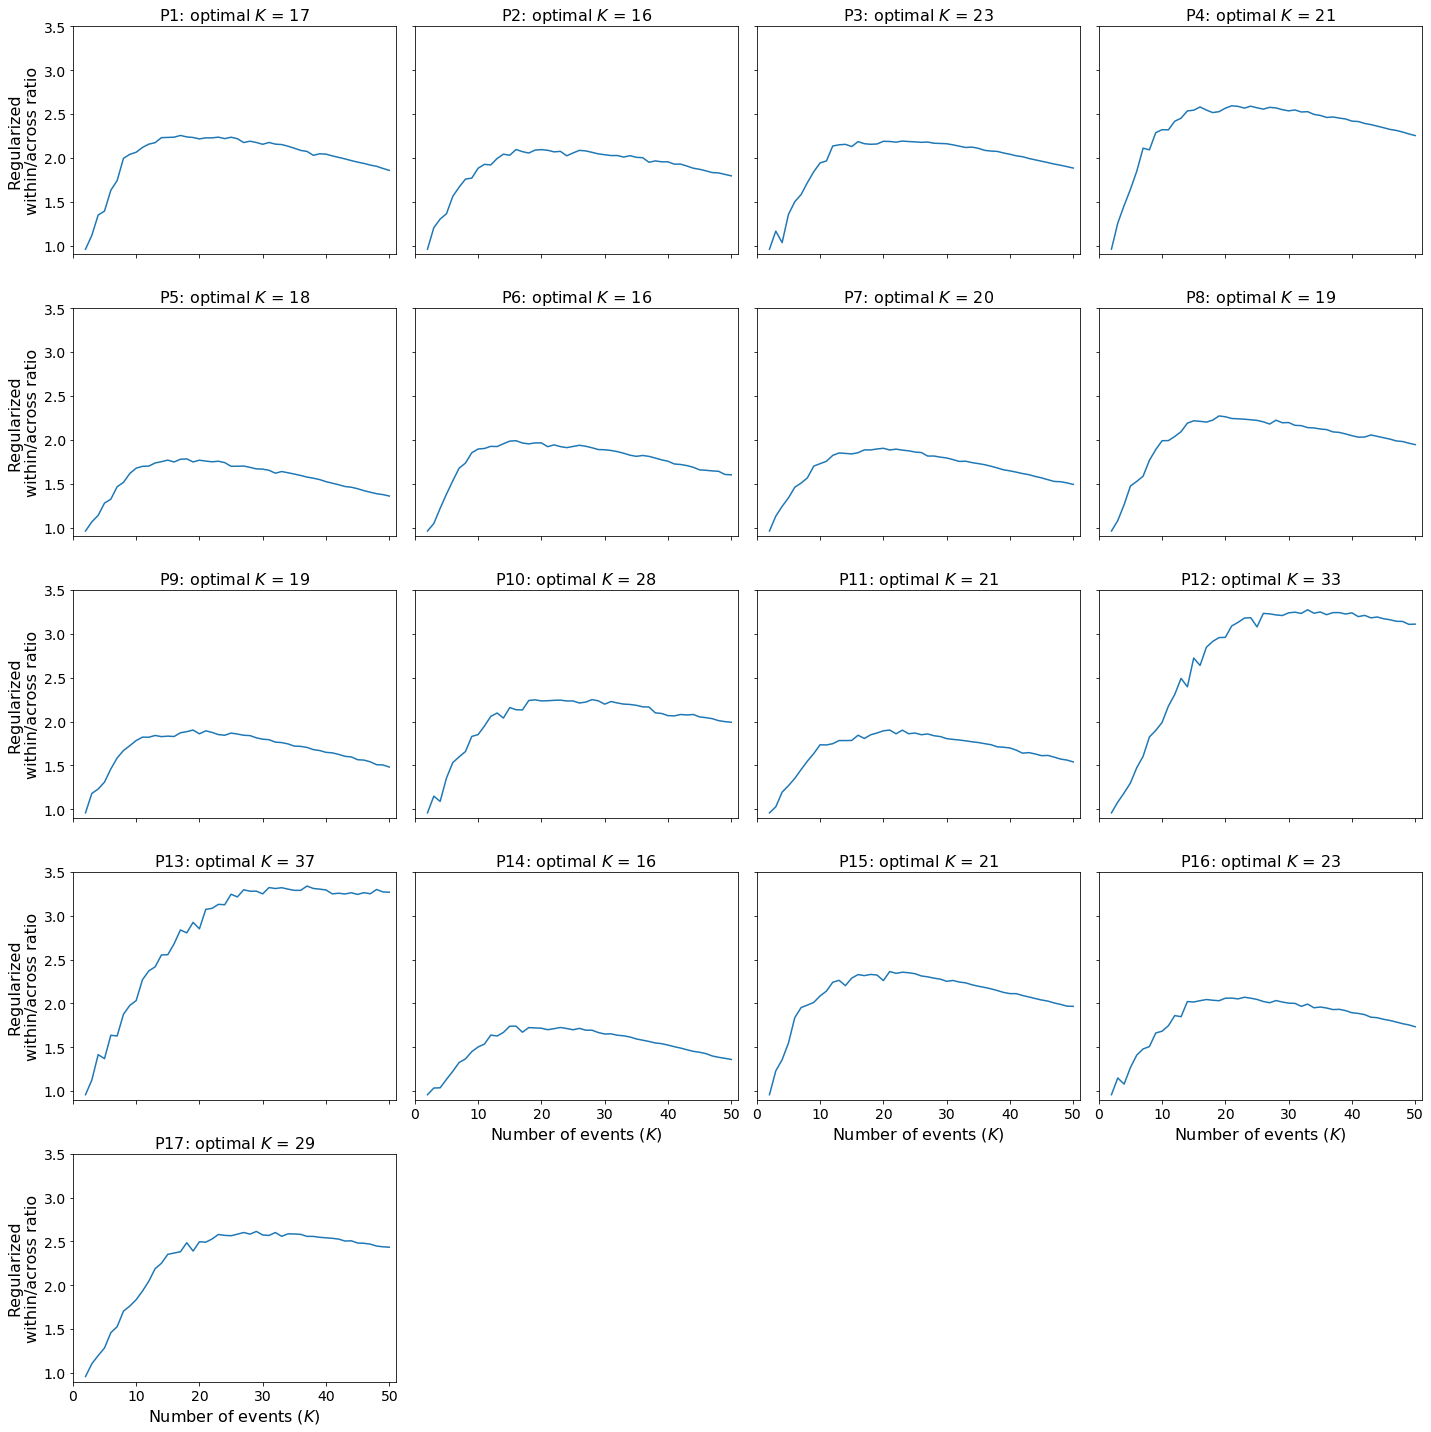

In [41]:
fig, axarr = plt.subplots(nrows=5, ncols=4, sharey=True)
fig.set_size_inches(20,20)
axarr = axarr.flatten()

ks = list(range(2, 51))
maxk_rec = []

for (sub, cs), ax in zip(sub_cs.items(), axarr):
    ratios = list(map(lambda x: x[0]/(x[1]-min([i[2] for i in cs])), cs))
    ratios /= np.max(ratios)
    for i, ratio in enumerate(ratios):
        ratios[i] -= (i+2)/50
        
    m = ks[np.argmax(ratios)]
    maxk_rec.append(m)
    
    ax.plot([np.nan]*2 + list(ratios))
    ax.set_xticks(list(range(0, 51, 10)))
    ax.set_xlim(0, 51)
    ax.set_ylim(.9, 3.5)
    
    if not sub % 4:
        ax.set_ylabel('Regularized\nwithin/across ratio', fontsize=16)
        ax.tick_params(axis='y', labelsize=14)
    else:
        ax.set_ylabel('')

    if sub >= 13:
        ax.set_xlabel('Number of events ($K$)', fontsize=16)
        ax.tick_params(axis='x', labelsize=14)
    else:
        ax.set_xlabel('')
        ax.set_xticklabels([])
        
    ax.set_title(f'P{sub+1}: optimal $K$ = {m}', fontsize=16)
    
axarr[-3].axis('off')
axarr[-2].axis('off')
axarr[-1].axis('off')
plt.tight_layout()
plt.subplots_adjust()
# plt.savefig('../../../paper/figs/k_optimization.pdf')
plt.show()

## Fit model to recall using best k

In [15]:
recall_events = []
recall_event_times = []
recall_eventseg_models = []
for i, k in enumerate(maxk_rec):
    ev = event.EventSegment(k)
    ev.fit(recall_models[i])
    m = reduce_model(recall_models[i], ev)
    recall_events.append(m)
    recall_times = []
    for s in ev.segments_[0].T:
        tp = np.where(np.round(s)==1)[0]
        recall_times.append((tp[0], tp[-1]))
    recall_event_times.append(recall_times)
    recall_eventseg_models.append(ev)

## Create average recall model

In [16]:
matches = np.array([np.argmax(1 - cdist(video_events, r, 'correlation'), 0) for r in recall_events])
avg_recalls = [[] for _ in video_events]
for match, r in zip(matches, recall_events):
    for i, m in enumerate(match):
        avg_recalls[m].append(r[i,:])
avg_recall_events = np.array(list(map(lambda r: np.mean(r, 0) if len(r)>0 else np.zeros((100,)), avg_recalls)))

## Create 2D embeddings

In [17]:
np.random.seed(140)
embeddings = hyp.reduce(recall_events+[video_events]+[avg_recall_events], reduce='UMAP', ndims=2)

## Save models

In [18]:
np.save(datadir+'avg_recall_events', avg_recall_events)
np.save(datadir+'embeddings', embeddings)
np.save(datadir+'labels', matches)
np.save(datadir+'recall_events', recall_events)
np.save(datadir+'recall_event_times', recall_event_times)
with open(datadir+'recall_eventseg_models', 'wb') as f:
    pickle.dump(recall_eventseg_models, f)